# **1- Packages**

In [ ]:
!pip install scikeras

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.layers import Dense, Flatten, LSTM, Bidirectional, Input, Dropout, InputLayer, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras

# **2- Data Preparation & EDA**

In [25]:
df = pd.read_csv('EEG_data.csv')
df

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,9.0,9.0,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,1.0,0.0
12807,9.0,9.0,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,1.0,0.0
12808,9.0,9.0,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,1.0,0.0
12809,9.0,9.0,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,1.0,0.0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB


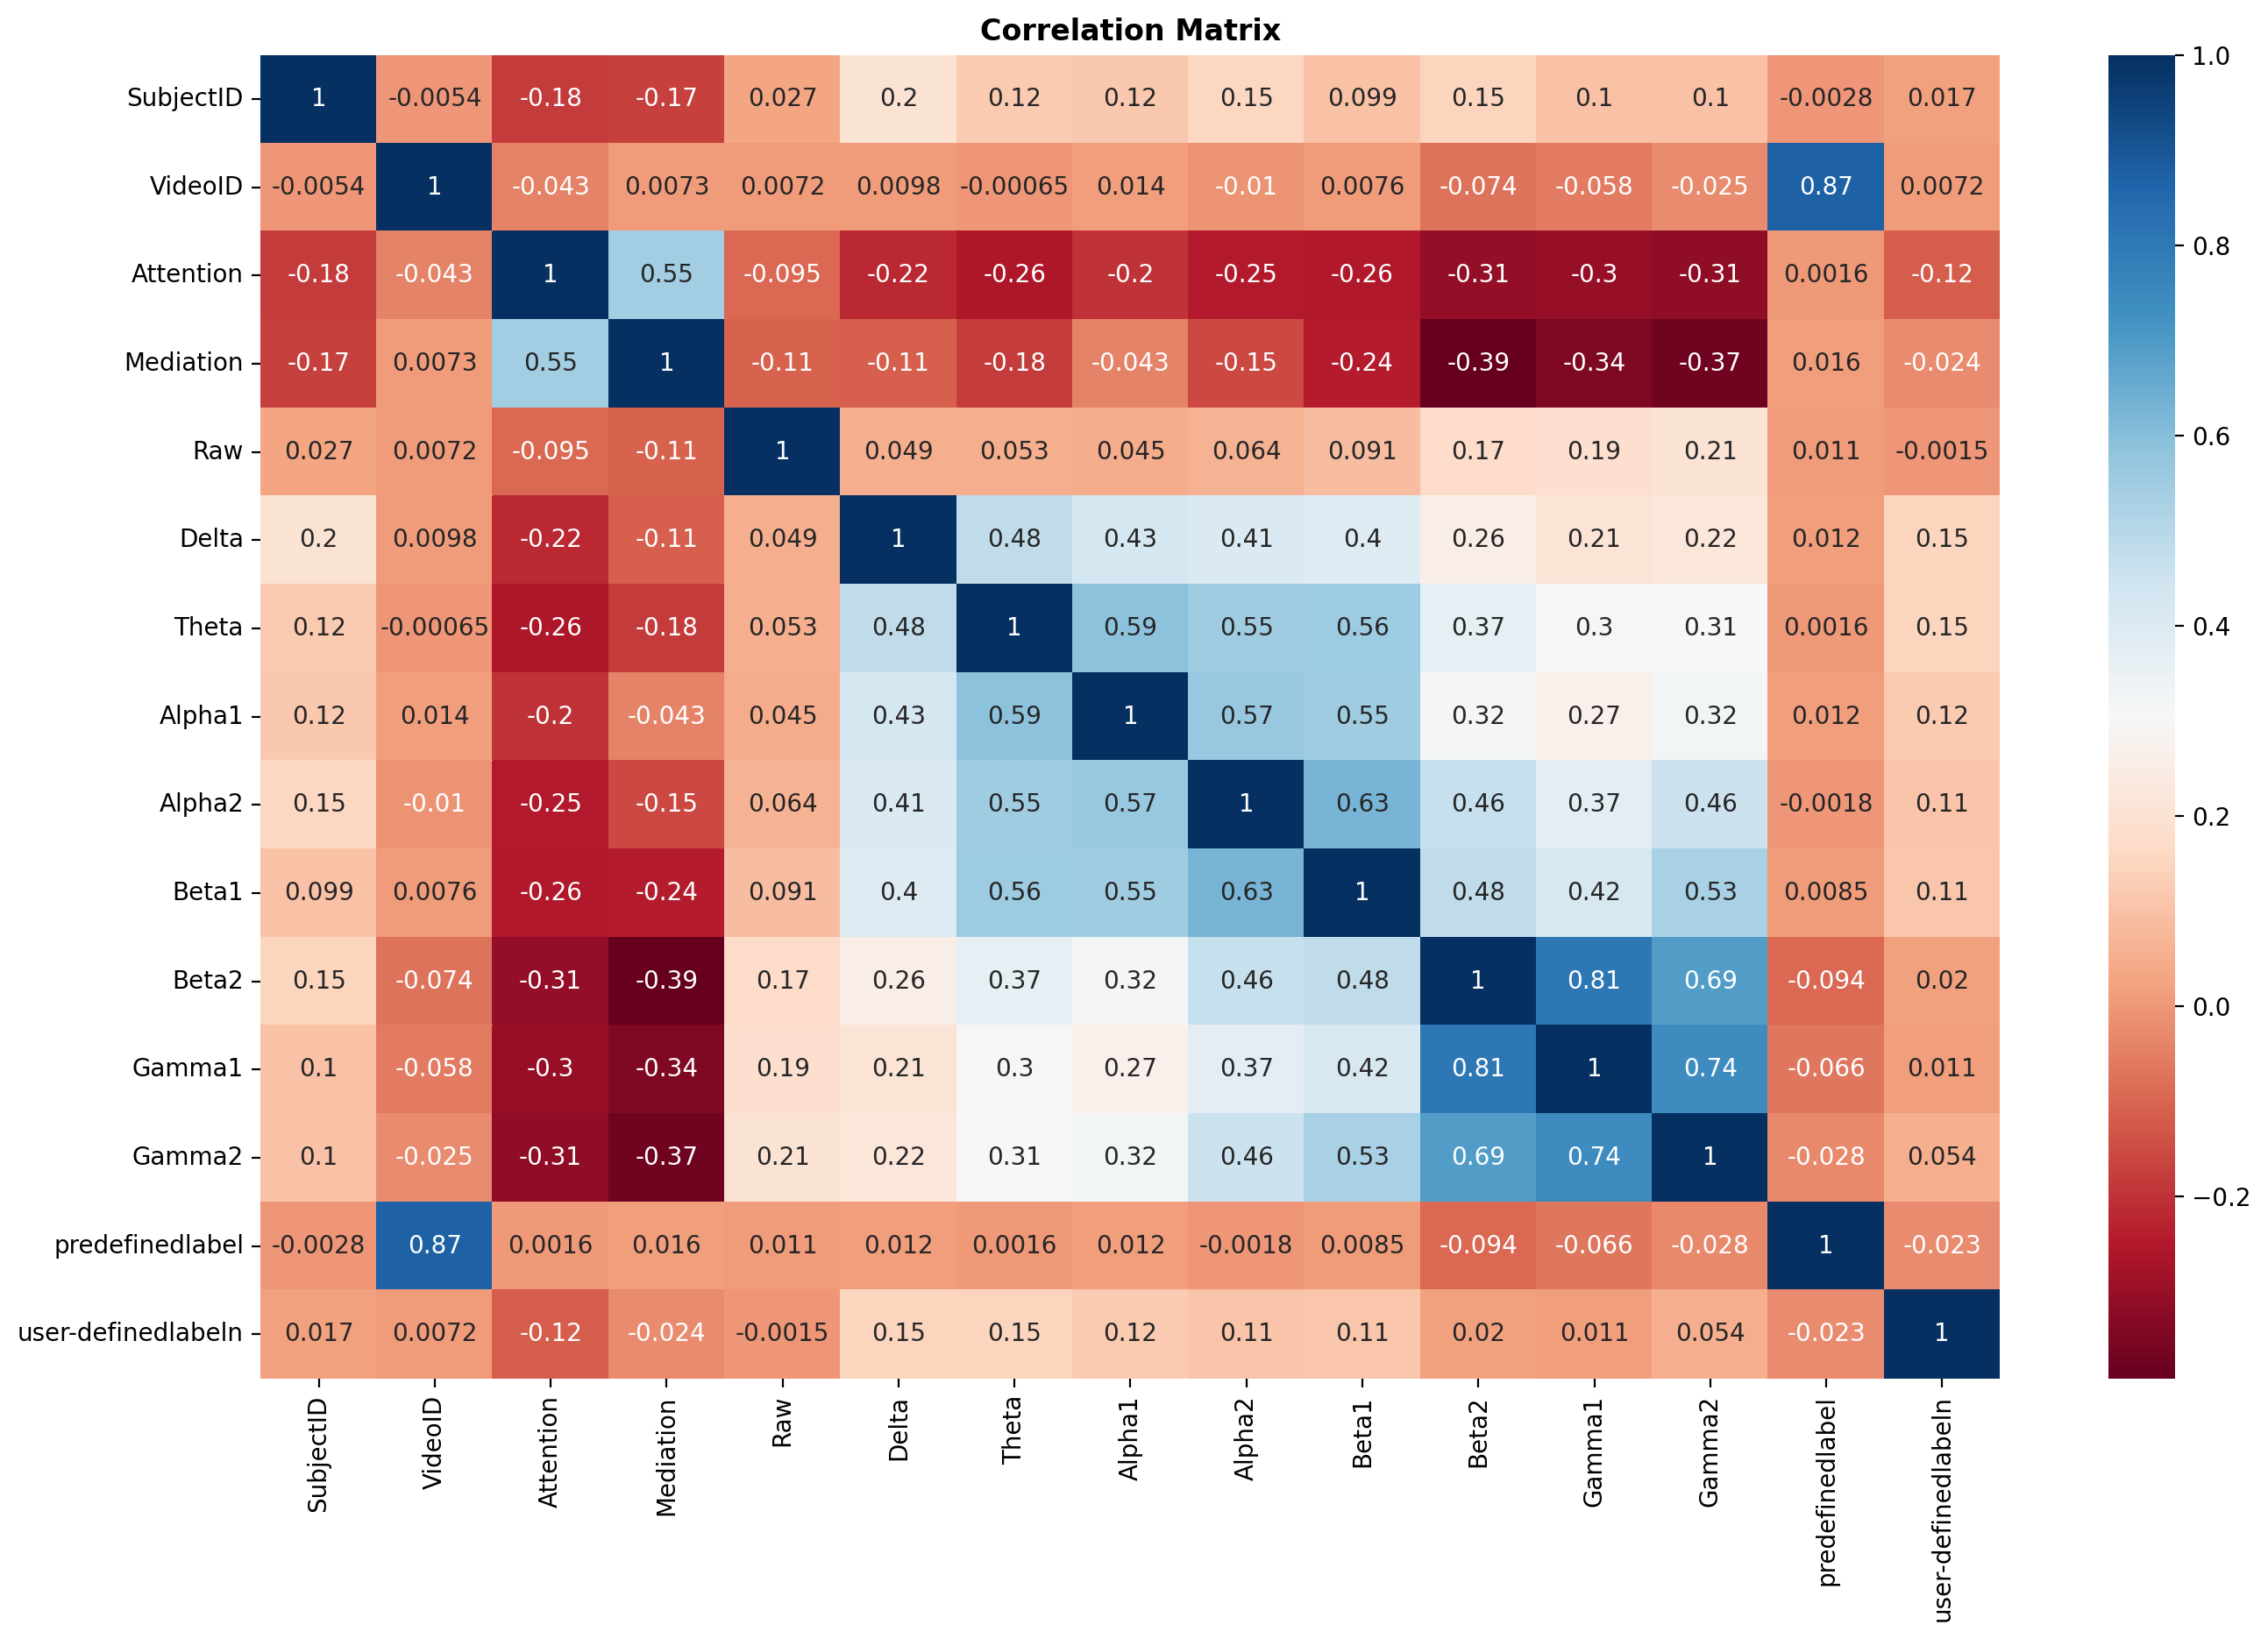

In [27]:
plt.figure(figsize = (16,10), dpi=200)
ax = plt.axes()
sns.heatmap(df.corr(), annot = True, cmap='RdBu', ax=ax)
ax.set_title('Correlation Matrix', weight='bold')
plt.show()

In [28]:
# Agrregate all rows corresponding to the same (user, video) pair
aggregated = [
    [e for e in df.values if e[0] == subjectid and e[1] == videoid]
    for subjectid in range(10) for videoid in range(10)
]

In [29]:
# Ensure that all data objects are of the same shape (same number of rows)
# We find the minimal # of rows and truncate all longer ones
print(min(len(p) for p in aggregated)) # shortest length = 112
aggregated = np.array([p[:112] for p in aggregated])
aggregated.shape

112


(100, 112, 15)

In [30]:
# Split features (X) and labels (y)
X = [[] for i in range(100)]
y = [[] for i in range(100)]
for i, p in enumerate(aggregated):
  for row in p:
    X[i].append(row[2:13])
  y[i] = row[14]
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(100, 112, 11)
(100,)


In [31]:
# Example of the features of the first data objects - dimension 112 x 11
pd.DataFrame(X[0])

,0,1,2,3,4,5,6,7,8,9,10
0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0
1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0
2,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0
3,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0
4,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0
...,...,...,...,...,...,...,...,...,...,...,...
107,48.0,64.0,40.0,162741.0,14524.0,8462.0,1697.0,3479.0,3596.0,2617.0,3273.0
108,54.0,67.0,-25.0,127555.0,44482.0,21549.0,36369.0,35485.0,60862.0,45573.0,47922.0
109,40.0,66.0,153.0,621932.0,119673.0,18490.0,9414.0,16178.0,18829.0,17780.0,9739.0
110,38.0,64.0,200.0,2521371.0,433788.0,228893.0,44669.0,108535.0,44725.0,117066.0,34900.0


In [32]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'X_train: {X_train.shape}\ny_train: {y_train.shape}\nx_test:  {x_test.shape}\ny_test:  {y_test.shape}')

X_train: (80, 112, 11)
y_train: (80,)
x_test:  (20, 112, 11)
y_test:  (20,)


# **3- Training**

## **3.1 LSTM**

In [34]:
batch_size = [2, 4]
epochs = [10]
optimizers = ['adam', 'rmsprop']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers)
param_grid

{'batch_size': [2, 4], 'epochs': [10], 'optimizer': ['adam', 'rmsprop']}

In [35]:
def LSTM_Model(optimizer='adam'):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(112,11),axis=2))
    model.add(LSTM(100, return_sequences=False, input_shape=(112,12)))
    model.add(Dense(112, activation='hard_sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['binary_accuracy'])
    return model

In [36]:
# Final Training
batch_size=30

lstm_model = LSTM_Model()
#model,history = train_model(lstm_model, X_train, y_train, x_test, y_test, save_to= './', epoch = 30) 
lstm_hist = lstm_model.fit(X_train, y_train,
                           validation_data=(x_test, y_test),
                           epochs=30,
                           steps_per_epoch=X_train.shape[0]//batch_size)

Epoch 1/30
2/2 [==============================] - 2s 437ms/step - loss: 0.6934 - binary_accuracy: 0.5059 - val_loss: 0.7005 - val_binary_accuracy: 0.5103
Epoch 2/30
2/2 [==============================] - 0s 35ms/step - loss: 0.6900 - binary_accuracy: 0.5416 - val_loss: 0.6994 - val_binary_accuracy: 0.5112
Epoch 3/30
2/2 [==============================] - 0s 49ms/step - loss: 0.6846 - binary_accuracy: 0.5805 - val_loss: 0.6968 - val_binary_accuracy: 0.5272
Epoch 4/30
2/2 [==============================] - 0s 34ms/step - loss: 0.6664 - binary_accuracy: 0.6335 - val_loss: 0.6916 - val_binary_accuracy: 0.5496
Epoch 5/30
2/2 [==============================] - 0s 35ms/step - loss: 0.6403 - binary_accuracy: 0.6653 - val_loss: 0.6796 - val_binary_accuracy: 0.5844
Epoch 6/30
2/2 [==============================] - 0s 45ms/step - loss: 0.6352 - binary_accuracy: 0.6571 - val_loss: 0.6641 - val_binary_accuracy: 0.6254
Epoch 7/30
2/2 [==============================] - 0s 35ms/step - loss: 0.6186 - b

In [37]:
# Final evaluation of the model
scores = lstm_model.evaluate(x_test, y_test, batch_size = batch_size, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.00%


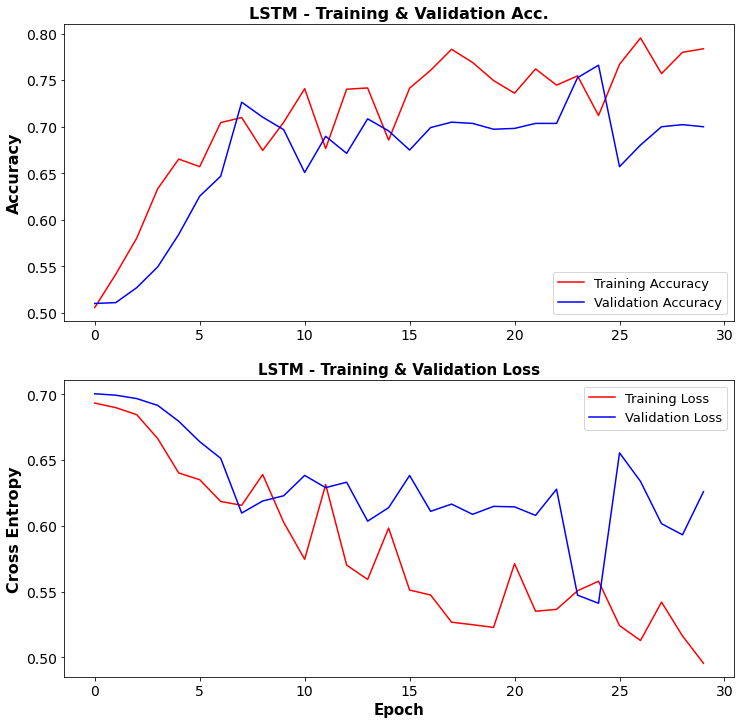

In [38]:
%matplotlib inline

acc = lstm_hist.history['binary_accuracy']
val_acc = lstm_hist.history['val_binary_accuracy']

loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()